---
title: "Visualising the Geographic Distribution of Charity Donors with Interactive Leaflet Maps"
author: "Daniel J Smith"
date: "2024-03-17"
categories: [Python, EH]
title-block-banner: false
jupyter: python3
image: 'preview.png'
draft: false
description: "An anonymised display of voluntary work conducted for Emmanuel House Support centre. Post 2/5 in the series."
---

In [124]:
import pandas as pd
import numpy as np
import folium
from branca.colormap import LinearColormap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Data Imports

`FakeIndividualConstituents.csv` is a dataset I constructed consisting of the donation details of 100 fictional donors to a charity in Nottingham. 

This post is meant to illustrate my method for investigating the distribution of donors to a real charity at which I volunteer - [Emmanuel House](https://www.emmanuelhouse.org.uk/) in Nottingham. 

`Newsletter` is a binary feature labelling if the donor is subscribed to the charity's newsletter.

{{< downloadthis files/FakeIndividualConstituents.csv dname="FakeIndividualConstituents" label="Download `FakeIndividualConstituents.csv`" icon="database-fill-down" type="info" >}}

In [146]:
df = pd.read_csv('files/FakeIndividualConstituents.csv')
df.head()

Postcode  NumberDonations  TotalDonated  AverageDonated  Newsletter
0  NG9 3WF                4            61           15.25           1
1  NG9 4WP                1            23           23.00           0
2  NG9 3EL                1            30           30.00           0
3  NG1 9FH                5            75           15.00           1
4  NG5 6QZ                1            15           15.00           0

In [175]:
df[5:].sample(5)

Postcode  NumberDonations  TotalDonated  AverageDonated  Newsletter
64  NG8 3HT                9           153           17.00           1
98  NG3 1FF                3            56           18.67           1
12  NG1 3RD                1            15           15.00           0
54  NG5 3FD                3            48           16.00           1
9   NG9 4AX                1            17           17.00           0

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Postcode         100 non-null    object 
 1   NumberDonations  100 non-null    int64  
 2   TotalDonated     100 non-null    int64  
 3   AverageDonated   100 non-null    float64
 4   Newsletter       100 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 4.0+ KB


In [148]:
df.describe()

NumberDonations  TotalDonated  AverageDonated  Newsletter
count       100.000000    100.000000       100.00000  100.000000
mean          4.320000    250.150000        46.51950    0.500000
std           5.454828   1657.135245       212.23961    0.502519
min           1.000000     15.000000        15.00000    0.000000
25%           1.000000     30.000000        15.00000    0.000000
50%           2.000000     45.000000        15.19000    0.500000
75%           5.000000     92.000000        16.92500    1.000000
max          37.000000  16618.000000      2077.25000    1.000000

# Geocoding Postcodes with ONS data

For the details of this geocoding process, see my previous blog post:

[Geocoding Postcodes in Python: pgeocode v ONS](https://danieljamessmith.github.io/blog/posts/eh1/)

In [149]:
post = pd.read_csv(r'C:\Users\Daniel\Downloads\open_postcode_geo.csv\open_postcode_geo.csv', header=None)
post = post[[0, 7, 8]]
post = post.rename({0: 'Postcode', 7: 'Latitude', 8: 'Longitude'}, axis=1)

df = df.merge(post, on='Postcode', how='left')

df.head()

Postcode  NumberDonations  TotalDonated  AverageDonated  Newsletter  \
0  NG9 3WF                4            61           15.25           1   
1  NG9 4WP                1            23           23.00           0   
2  NG9 3EL                1            30           30.00           0   
3  NG1 9FH                5            75           15.00           1   
4  NG5 6QZ                1            15           15.00           0   

    Latitude  Longitude  
0  52.930121  -1.198353  
1  52.921587  -1.247504  
2  52.938985  -1.239510  
3  52.955008  -1.141045  
4  52.996670  -1.106307

# Visualising Donor Data with Interactive Folium Maps

[Folium](https://python-visualization.github.io/folium/latest/#) is a Python library providing the functionality to visualise data in the form of interactive leaflet (.html) maps.

## First Map

Producing a basic folium map with no extra features:

In [150]:
m = folium.Map(location=[52.9548, -1.1581], zoom_start=12)

for index, row in df.iterrows():  
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color='blue', 
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
    ).add_to(m)
    
m.save('FakeDonorMap1.html')
m

## Adding Colour Labelling

We can colour each point by the value of `TotalDonated` using `LinearColormap` from `branca.colormap`:

In [153]:
m = folium.Map(location=[52.9548, -1.1581], zoom_start=12)

colors = ['green', 'yellow', 'orange', 'red', 'purple']
linear_colormap = LinearColormap(colors=colors,
                                 index=[0, 100, 250, 500, 1000],
                                 vmin=df['TotalDonated'].min(),
                                 vmax=df['TotalDonated'].quantile(0.99025))

for index, row in df.iterrows():    
    
    total_don = row['TotalDonated']
    color = linear_colormap(total_don)
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color=color, 
        fill=True,
        fill_color=color,
        fill_opacity=1,
    ).add_to(m)

linear_colormap.add_to(m)

m.save('FakeDonorMap2.html')
m

## Adding Pop-Ups

Next, I added a pop-up to each data point showing the user the data of that donor by adding an argument `popup` to `folium.CircleMarker`:

In [154]:
m = folium.Map(location=[52.9548, -1.1581], zoom_start=12)

colors = ['green', 'yellow', 'orange', 'red', 'purple']
linear_colormap = LinearColormap(colors=colors,
                                 index=[0, 100, 250, 500, 1000],
                                 vmin=df['TotalDonated'].min(),
                                 vmax=df['TotalDonated'].quantile(0.99025))

for index, row in df.iterrows():    
    num_don = row['NumberDonations']
    total_don = row['TotalDonated']
    news = bool(row['Newsletter'])
    avg_don = row['AverageDonated']
    
    popup_text = f'<div style="width: 175px;">\
                  Total Donated: £{total_don:.2f}<br>\
                  Number of Donations: {num_don}<br>\
                  Average Donation: £{avg_don:.2f}<br>\
                  Subscribed to Newsletter: {news}\
                  </div>'
    
    color = linear_colormap(total_don)
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color=color, 
        fill=True,
        fill_color=color,
        fill_opacity=1,
        popup=popup_text
    ).add_to(m)

linear_colormap.add_to(m)

m.save('FakeDonorMap_noLayerControl.html')
m

Showing a screenshot taken with ShareX using Matplotlib:

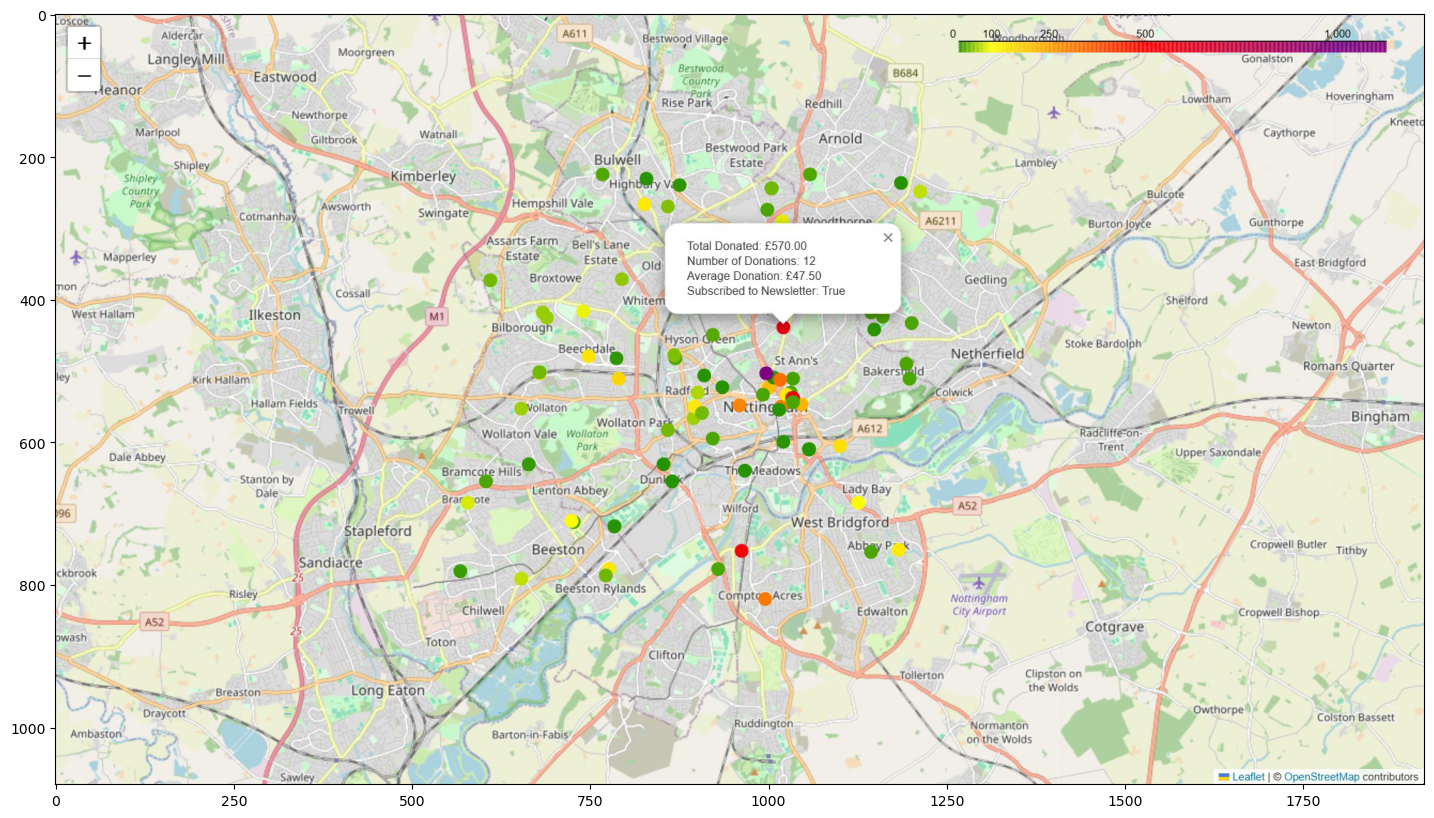

In [155]:
plt.figure(figsize=(20,10))
img = mpimg.imread('FakeDonorMap_noLayerControl.jpg')
imgplot = plt.imshow(img)
plt.show()

## Adding Layer Control

Finally, I added layer control to the map using `folium.map.FeatureGroup` and `folium.LayerControl`.

This results in buttons being added to the right of the UI, under the colour bar, allowing the user to show/hide the markers for donors in specific ranges of donation totals.

I used [Microsoft Copilot](https://copilot.microsoft.com/) to assist with this step.

In [157]:
m = folium.Map(location=[52.9548, -1.1581], zoom_start=12)

colors = ['green', 'yellow', 'orange', 'red', 'purple']
linear_colormap = LinearColormap(colors=colors,
                                 index=[0, 100, 250, 500, 1000],
                                 vmin=df['TotalDonated'].min(),
                                 vmax=df['TotalDonated'].quantile(0.99025))

# Create FeatureGroups
fgroups = [folium.map.FeatureGroup(name=f"Total Donated:  £{lower}-£{upper}") for lower, upper in zip([0, 100, 250, 500, 750, 1000], [100, 250, 500, 750, 1000, float('inf')])]

for index, row in df.iterrows():    
    num_don = row['NumberDonations']
    total_don = row['TotalDonated']
    news = bool(row['Newsletter'])
    avg_don = row['AverageDonated']
    
    popup_text = f'<div style="width: 175px;">\
                  Total Donated: £{total_don:.2f}<br>\
                  Number of Donations: {num_don}<br>\
                  Average Donation: £{avg_don:.2f}<br>\
                  Subscribed to Newsletter: {news}\
                  </div>'
    
    color = linear_colormap(total_don)
    
    marker = folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color=color, 
        fill=True,
        fill_color=color,
        fill_opacity=1,
        popup=popup_text
    )
    
    # Add the marker to the appropriate FeatureGroup
    for fgroup, (lower, upper) in zip(fgroups, zip([0, 100, 250, 500, 750, 1000], [100, 250, 500, 750, 1000, float('inf')])):
        if lower <= total_don < upper:
            fgroup.add_child(marker)
            break

# Add the FeatureGroups to the map
for fgroup in fgroups:
    m.add_child(fgroup)

linear_colormap.add_to(m)
m.add_child(folium.LayerControl())


m.save('FakeDonorMap_withLayerControl.html')
m

Showing a screenshot taken with ShareX using Matplotlib:

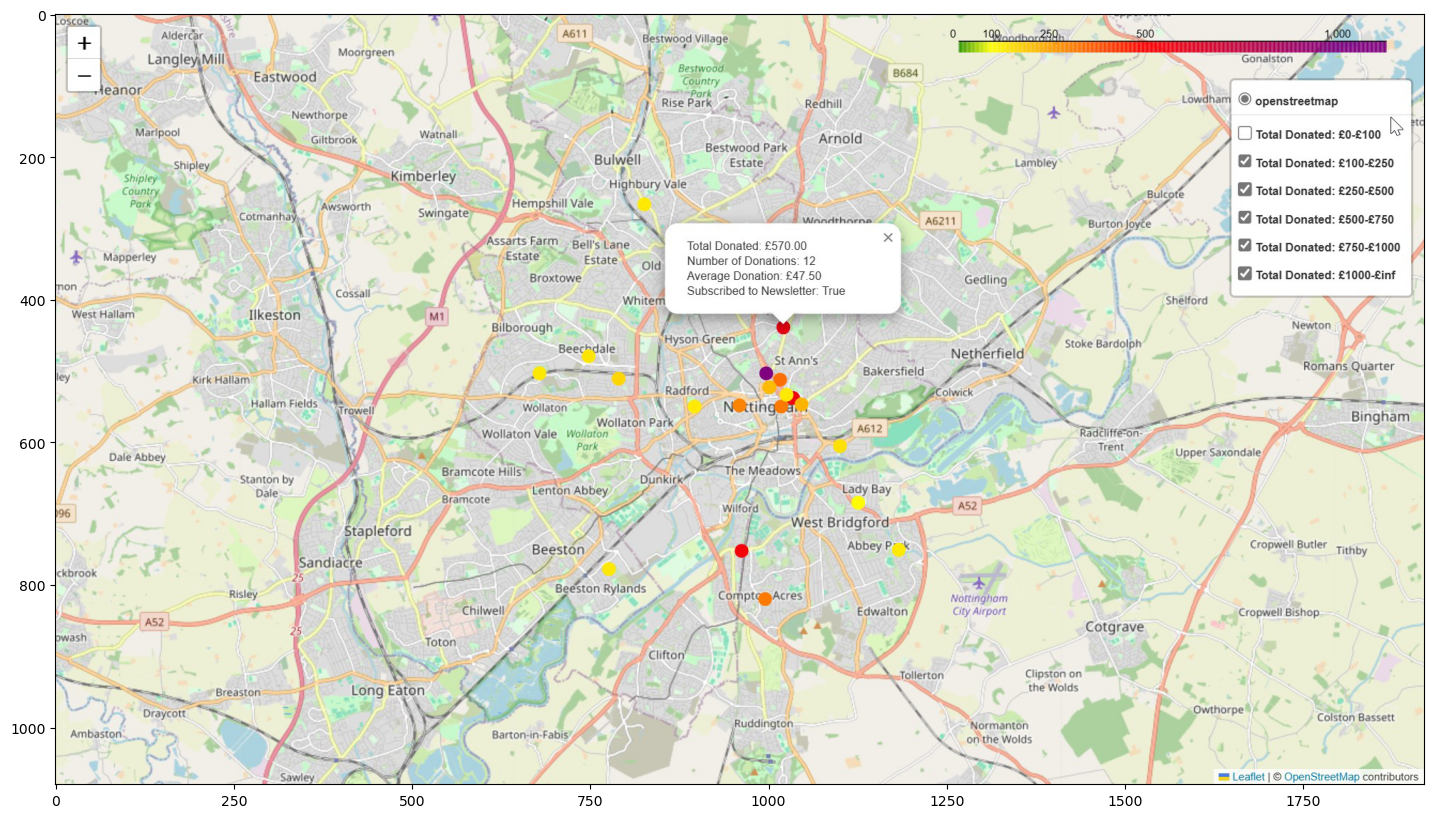

In [158]:
plt.figure(figsize=(20,10))
img = mpimg.imread('FakeDonorMap_withLayerControl.jpg')
imgplot = plt.imshow(img)
plt.show()

# Constructing the Fake Data

I started with `nottm_postcodes.csv`, the csv file of 100 random Nottingham postcodes I used in my previous post:

[Geocoding Postcodes in Python: pgeocode v ONS](https://danieljamessmith.github.io/blog/posts/5%20-%20Geocoding%20Postcodes%20with%20Python/)

{{< downloadthis files/nottm_postcodes.csv dname="nottm_postcodes" label="Download `nottm_postcodes.csv`" icon="database-fill-down" type="info" >}}

In [159]:
df = pd.read_csv('files/nottm_postcodes.csv')
df.head()

Postcode
0  NG9 3WF
1  NG9 4WP
2  NG9 3EL
3  NG1 9FH
4  NG5 6QZ

I then defined `NumberDonations` using a standard normal distribution via `np.random.randn`, adding 1 using Python broadcasting to ensure each donor has donated at least one time.

I initially tried to produce the number of donations by uniformly generating a random integer between 1 and 40. However, this resulted in a mean number of donations of ~20 which was not at all representative of the real data. 

Raising 5 to the power of the standard normal random variable generated by `np.random.randn` and adding 1 resulted in a `NumberDonations` column with a more realistic distribution.

In [160]:
num_donations = 1 + np.round(5**np.random.randn(100))
df['NumberDonations'] = pd.Series(num_donations).astype(int)
df['NumberDonations'].describe()

count    100.000000
mean       3.920000
std        5.104326
min        1.000000
25%        1.000000
50%        2.000000
75%        3.250000
max       34.000000
Name: NumberDonations, dtype: float64

I wanted the `TotalDonated` column to postively correlate with the `NumberDonations` column but not be entirely determined by it.

I settled on the approach of multiplying the `NumberDonations` column by 15 and adding to this 20 raised to the power of another standard normal random variable. Including the second normal random variable adds random noise to this `TotalDonated` column, meaning it isn't entirely determined by `NumberDonations`.

The distribution of `TotalDonated` is not at all perfect, but suffices for the purposes of this post.

In [161]:
total_donated = np.round(np.abs(15*num_donations + 20**np.random.randn(100)))
df['TotalDonated'] = pd.Series(total_donated).astype(int)
df['TotalDonated'].describe()

count    100.000000
mean      69.340000
std       86.320196
min       15.000000
25%       30.000000
50%       33.000000
75%       61.500000
max      512.000000
Name: TotalDonated, dtype: float64

In [162]:
df.corr(numeric_only=True)

NumberDonations  TotalDonated
NumberDonations         1.000000      0.916614
TotalDonated            0.916614      1.000000

The `AverageDonated` column is simply `TotalDonated` divided by `NumberDonations`

In [163]:
df['AverageDonated'] = np.round(df['TotalDonated']/df['NumberDonations'], decimals=2)
df['AverageDonated'].describe()

count    100.000000
mean      19.372000
std       16.543806
min       15.000000
25%       15.000000
50%       15.070000
75%       16.425000
max      164.500000
Name: AverageDonated, dtype: float64

My first approach to generating the binary feature `Newsletter` was:

In [164]:
newsletter = (np.random.rand(100) > 0.5).astype(int)
df['Newsletter'] = pd.Series(newsletter)
df['Newsletter'].describe()

count    100.00
mean       0.55
std        0.50
min        0.00
25%        0.00
50%        1.00
75%        1.00
max        1.00
Name: Newsletter, dtype: float64

However I wanted the binary `Newsletter` feature to positively correlate with `TotalDonated` but again not be entirely determined by it. The approach above results in an entirely randomly chosen `Newsletter` with 0 correlation to `TotalDonated`.

In [165]:
df.corr(numeric_only=True)

NumberDonations  TotalDonated  AverageDonated  Newsletter
NumberDonations         1.000000      0.916614       -0.078951    0.112402
TotalDonated            0.916614      1.000000        0.297428    0.061388
AverageDonated         -0.078951      0.297428        1.000000   -0.119316
Newsletter              0.112402      0.061388       -0.119316    1.000000

Upon the suggestion of Copilot I settled on the following:

In [166]:
def add_newsletter(df):
    # Create a score that is a combination of 'NumberDonations' and 'TotalDonated'
    score = df['NumberDonations'] + df['TotalDonated'] + df['NumberDonations'] * df['TotalDonated']

    # Add some random noise to 'Score'
    score += np.random.normal(0, 0.1, df.shape[0])

    # Create 'Newsletter' column by thresholding 'Score' such that the mean of 'Newsletter' is about 0.5
    threshold = np.percentile(score, 50)  # 50 percentile, i.e., median
    df['Newsletter'] = (score > threshold).astype(int)

    return df

In [167]:
df = add_newsletter(df)
df['Newsletter'].describe()

count    100.000000
mean       0.500000
std        0.502519
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: Newsletter, dtype: float64

In [168]:
df.corr(numeric_only=True)

NumberDonations  TotalDonated  AverageDonated  Newsletter
NumberDonations         1.000000      0.916614       -0.078951    0.472558
TotalDonated            0.916614      1.000000        0.297428    0.525571
AverageDonated         -0.078951      0.297428        1.000000    0.186624
Newsletter              0.472558      0.525571        0.186624    1.000000

Thus we arrive at the synthetic dataset. Note that this is not exactly the same as the one used above due to the random nature of the generation process.

In [169]:
df.head()

Postcode  NumberDonations  TotalDonated  AverageDonated  Newsletter
0  NG9 3WF               21           399           19.00           1
1  NG9 4WP                1            16           16.00           0
2  NG9 3EL               16           241           15.06           1
3  NG1 9FH                2            30           15.00           0
4  NG5 6QZ                1            15           15.00           0

In [171]:
df.sample(5)

Postcode  NumberDonations  TotalDonated  AverageDonated  Newsletter
11  NG13 8XS                2            30           15.00           0
9    NG9 4AX                1            17           17.00           0
52   NG2 6QB                1            19           19.00           0
34   NG1 1LF                3            85           28.33           1
85   NG7 5QX                1            15           15.00           0

In [172]:
df.describe()

NumberDonations  TotalDonated  AverageDonated  Newsletter
count       100.000000    100.000000      100.000000  100.000000
mean          3.920000     69.340000       19.372000    0.500000
std           5.104326     86.320196       16.543806    0.502519
min           1.000000     15.000000       15.000000    0.000000
25%           1.000000     30.000000       15.000000    0.000000
50%           2.000000     33.000000       15.070000    0.500000
75%           3.250000     61.500000       16.425000    1.000000
max          34.000000    512.000000      164.500000    1.000000

# Remarks and Further Directions

> The postcodes were randomly chosen from a certain latitude and longitude range encompassing Nottingham city. Thus there is no significance to the geographic distribution of the fake donors, while for the real data there were many interesting patterns to be investigated. For example, there is in fact a relationship between donor density and the social deprivation of areas of Nottingham not reflected in the synthetic data.
>
>
> Similarly, the number of donations for the fake dataset was randomly generated and the total donated was generated from the number of donations plus some transformed gaussian noise. In practice there is a relationship between the amount given by donors and where in Nottingham they live.
>
>
> I would be interested to investigate if I could find a way to make the fake dataset more accurately reflect the distribution of the true donor dataset without breaching any GDPR rules. 
>
>
> I have ideas of attaching statistics to the dataset, including population density, median income, IMD (Index of Multiple Deprivation) etc. I am currently invesigating this and it may be the topic of future blog posts. 
>
>
> Ultimately I want to train ML models on the donor dataset for the purposes of predictive modelling. I have tried some simple regression approaches, but want to conduct some more feature engineering on the dataset before prioritising this. 